In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import anndata 
from scipy.stats import fisher_exact

In [2]:
from matplotlib.pyplot import rc_context

In [3]:
base_dir = '//wynton//protected//home//ichs//tzack//FLC//Hyperammonemia//'
flc_dir = '//wynton//protected//home//ichs//tzack//FLC//'

In [4]:
df = pd.read_csv(base_dir+"labs_for_enc_with_max_ammonia_02032022.csv")

In [5]:
df = pd.read_csv(base_dir+"labs_for_enc_with_max_ammonia_02032022.csv")
df = df.drop('Unnamed: 0',axis=1)
#count number of nans in each row
nans_per_row = df.isnull().sum(axis=1)

df = df.drop(['Total_protein','PTT','PT','Fib'],axis=1)
df = df.drop_duplicates()

#selecting out hyperammonemia
df = df.loc[df['Ammonia']>=50,:].reset_index(drop=True)

HCC_df = pd.read_csv(flc_dir+"HCC_Binary_file_pt_exclusions_any_time_in_pt_history_new.csv")

#rounding age to nearest year (ish)
#age_at_dx = [0]*len(HCC_df)
#for i in range(len(age_at_dx)):
#    age_at_dx[i] = round(HCC_df.loc[i,'days_old_at_dx']/365)
##add this new column onto the original dataframe
#HCC_df['age_at_dx'] = age_at_dx
Dx_col = ['Not_HCC']*len(df)

#selecting out FLC patients
HCC_df['Dx'] = 'HCC'
#w.loc[w.female != 'female', 'female'] = 0
HCC_df.loc[HCC_df['FLC_dx']==1,'Dx'] = 'FLC'
df.insert(3, 'Dx', Dx_col)
FLC_pt = HCC_df.loc[HCC_df['Dx']=='FLC','Pt_ID'].tolist()
HCC_pt = HCC_df.loc[HCC_df['Dx']=='HCC','Pt_ID'].tolist()
df.loc[df['PatientDurableKey'].isin(FLC_pt),'Dx'] = 'FLC'
df.loc[df['PatientDurableKey'].isin(HCC_pt),'Dx'] = 'HCC'
#removing all nans
colnames = ['AST', 'ALT', 'Alk_phos', 'TBili', 'Ammonia','Na', 'K', 'Cl', 'CO2', 'BUN', 'Cr']
df_data = df.dropna(axis=0,subset = colnames,how='any').reset_index(drop=True)
df_labs_idx = ['EncounterKey']+colnames
df_labs = df_data.loc[:,df_labs_idx]
df_data['Dx1'] = df_data['Dx'].tolist()
df_data.loc[df_data['Dx1']=='HCC','Dx1'] = 'yHCC'
df_data.loc[df_data['Dx1']=='FLC','Dx1'] = 'zFLC'

In [6]:
len(df_data)

3066

In [7]:
len(df_data[df_data['Dx1']=='yHCC'])

295

In [8]:
#Z-score data (and shift to be all positive)
#for i in colnames:
#    data_cur = df_labs.loc[:,i]
#    mean_cur = np.mean(data_cur)
#    sd_cur = np.std(data_cur)
#    test = (data_cur-mean_cur)/sd_cur
#    df_labs.loc[:,i] = test

In [9]:
df_labs.to_csv('df_metabolic_labs_hyperammonemia_nans_removed.csv',index=False)

In [10]:
with open('df_metabolic_labs_hyperammonemia_nans_removed.csv') as your_data:
    adata = anndata.read_csv(your_data)

In [11]:
adata.obs["Dx"] = df_data['Dx1'].tolist()
colnames1 = list()
for i in colnames:
    colname_raw_cur = i+'_raw'
    colnames1.append(colname_raw_cur)
    adata.obs[colname_raw_cur] = df_labs[i].tolist()

In [12]:
#sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

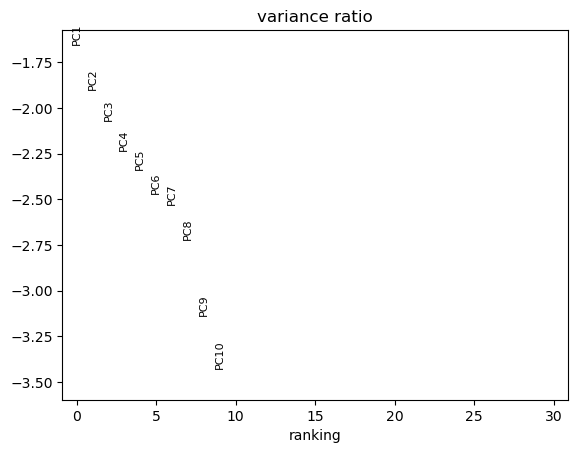

In [14]:
sc.pl.pca_variance_ratio(adata, log=True)

In [15]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40,metric='minkowski')

In [16]:
sc.tl.umap(adata,min_dist=0.15)


In [17]:
import leidenalg

In [18]:
sc.tl.leiden(adata,resolution = 0.20)

In [19]:
new_cluster_names = ['1','2','3','4','5','6','7','8']
adata.rename_categories('leiden', new_cluster_names)

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [20]:
adata_HCC = adata[adata.obs['Dx']!='Not_HCC',:]
adata_FLC = adata[adata.obs['Dx']=='zFLC',:]

In [21]:
#### THIS WILL ZSCORE DATA be CAREFUL sc.pp.scale(adata, max_value=100)

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Dx' as categorical


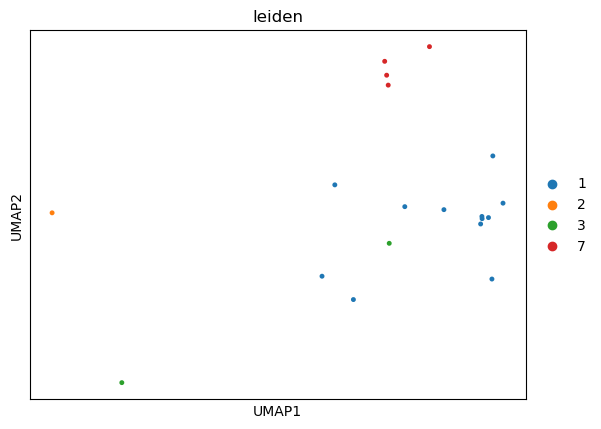

In [22]:
sc.pl.umap(adata_FLC, color=['leiden'],size=50,save='Metabolic_labs_hyperammonemia_FLC_only_umap_color_by_leiden.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Dx' as categorical


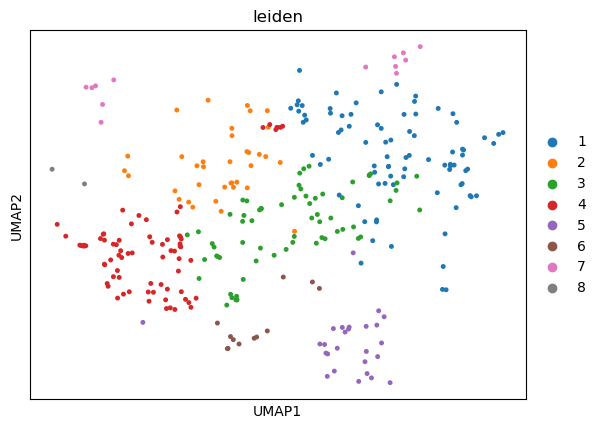

In [23]:
sc.pl.umap(adata_HCC, color=['leiden'],size=50,save='Metabolic_labs_hyperammonemia_HCC_only_umap_color_by_leiden.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Dx' as categorical


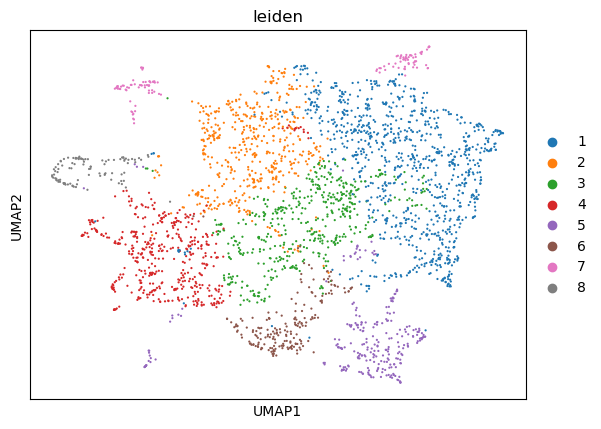

In [24]:
sc.pl.umap(adata, color=['leiden'],size=10,save='Metabolic_labs_hyperammonemia_umap_color_by_leiden_and_Dx.pdf')

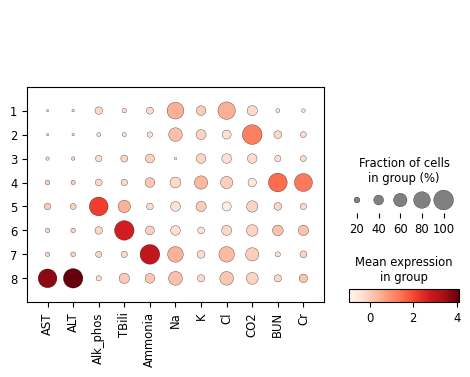

In [25]:
sc.pl.dotplot(adata, ['AST', 'ALT', 'Alk_phos', 'TBili', 'Ammonia','Na', 'K', 'Cl', 'CO2', 'BUN', 'Cr'], groupby='leiden', save ='Metabolic_labs_hyperammonemia_dotplot.pdf' );

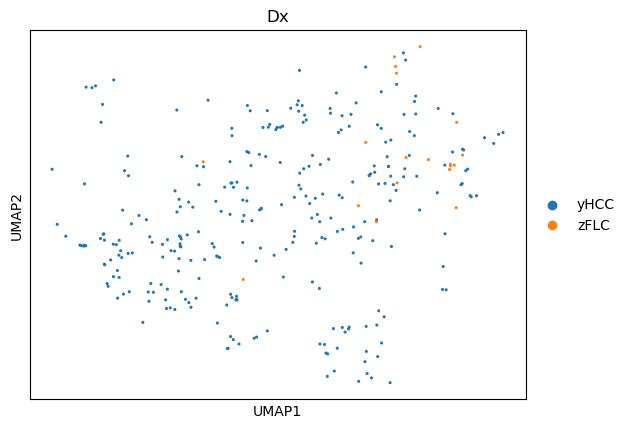

In [26]:
sc.pl.umap(adata_HCC, color=['Dx'],size=20,save='Metabolic_labs_hyperammonemia_umap_only_FLC_HCC.pdf')

#Create violin Plots

In [27]:
os.chdir('//wynton//protected//home//ichs//tzack//FLC//figures//Violin_plots//')

In [28]:
colnames1

['AST_raw',
 'ALT_raw',
 'Alk_phos_raw',
 'TBili_raw',
 'Ammonia_raw',
 'Na_raw',
 'K_raw',
 'Cl_raw',
 'CO2_raw',
 'BUN_raw',
 'Cr_raw']

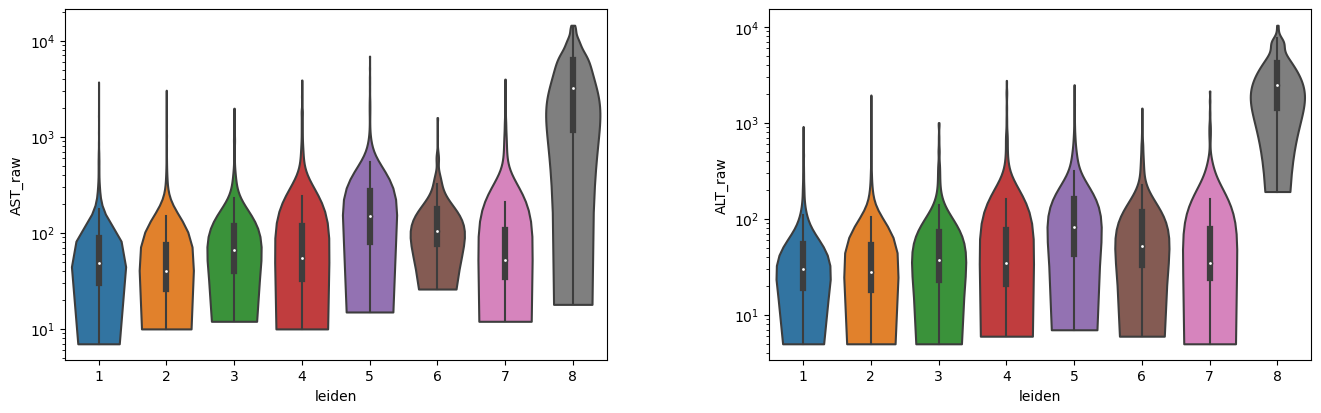

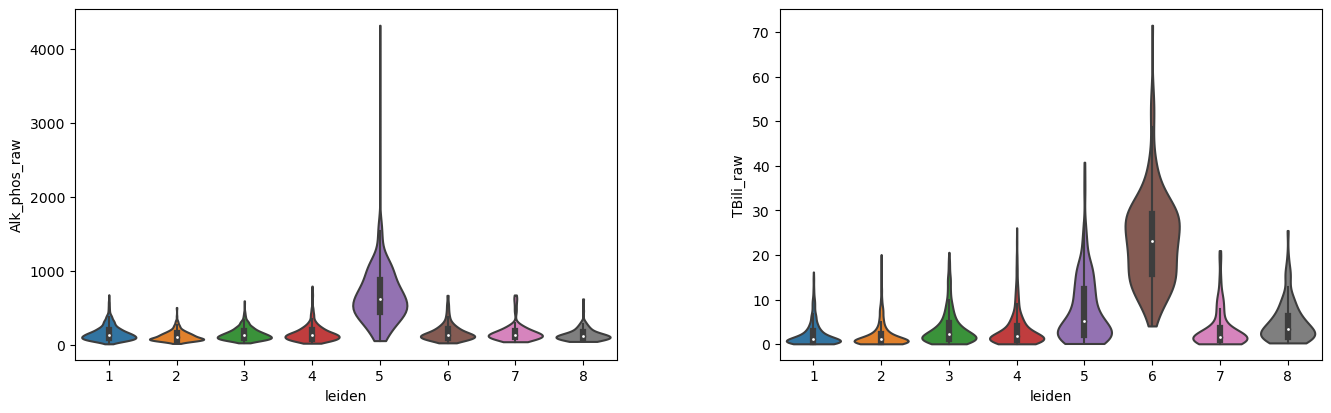

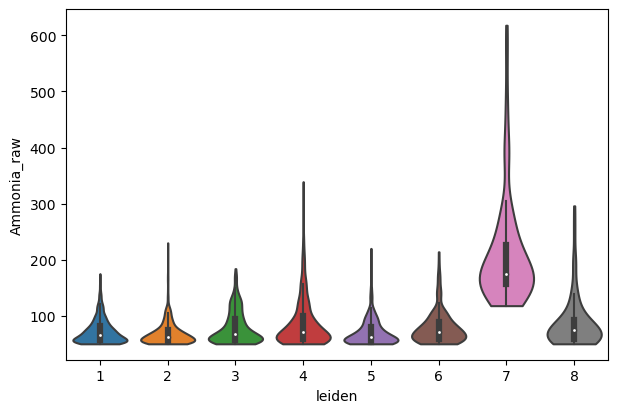

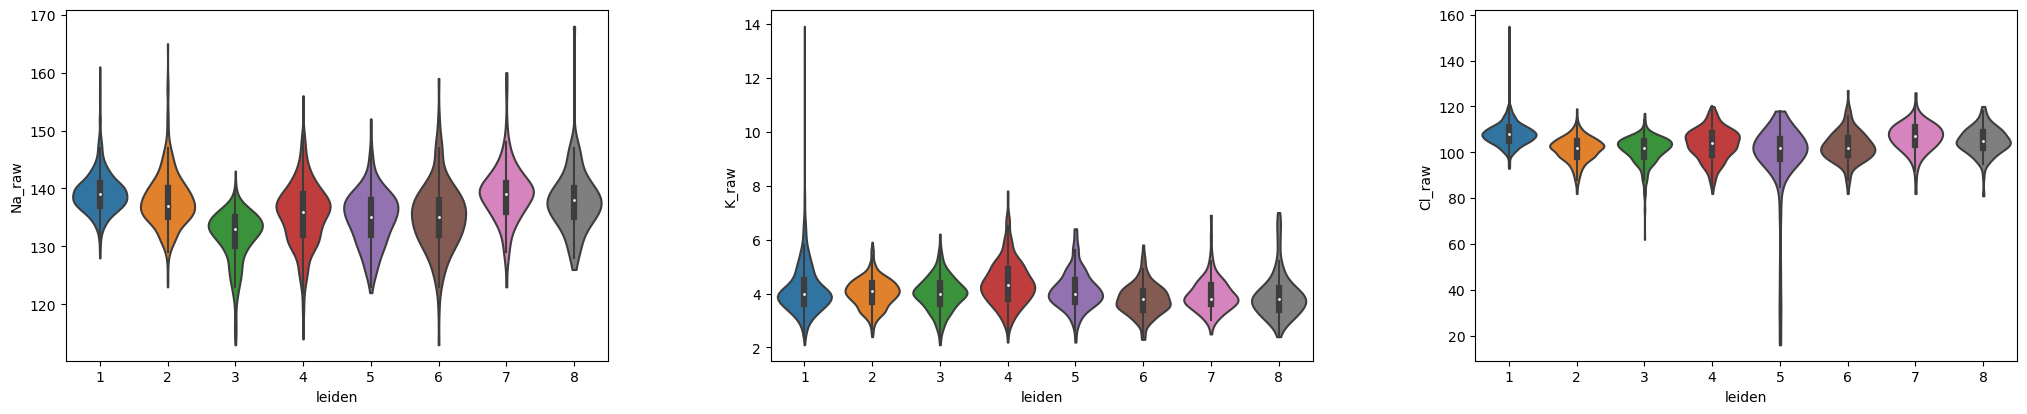

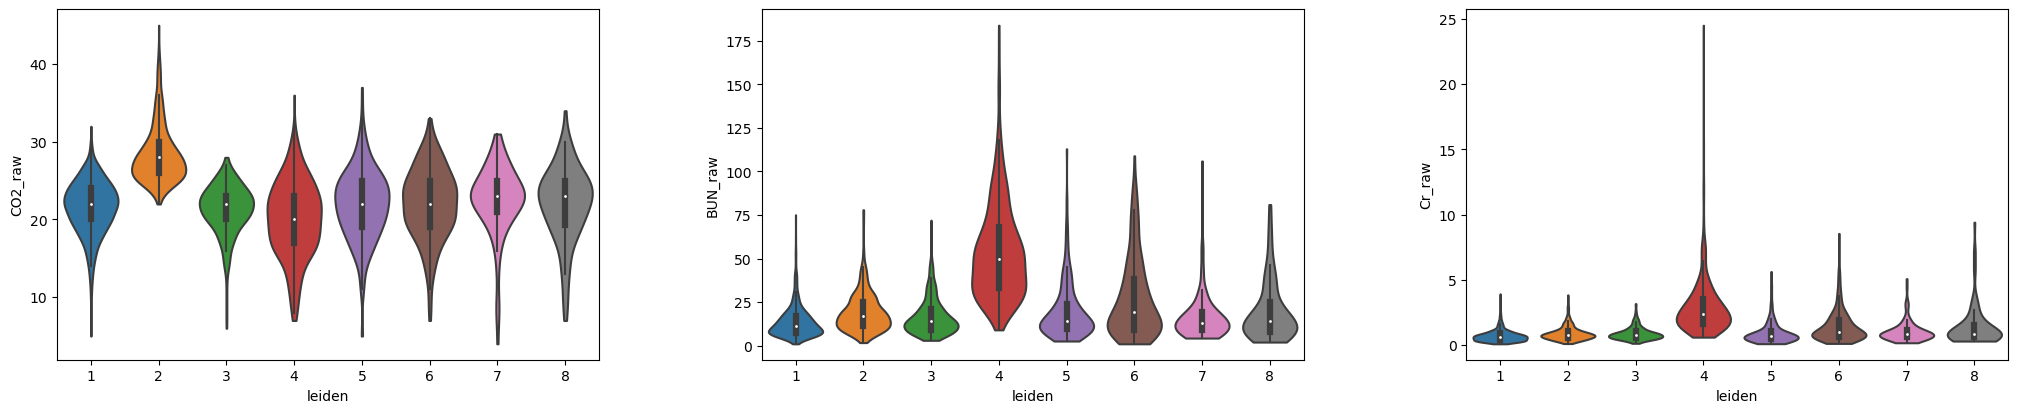

In [29]:
sc.pl.violin(adata, ['AST_raw','ALT_raw'], log=True,groupby='leiden', stripplot=False, inner='box',save="AST_ALT_Violin_plots_logscale_by_leiden.pdf")  
sc.pl.violin(adata, ['Alk_phos_raw','TBili_raw'], groupby='leiden', stripplot=False, inner='box',save="Alkphos_TBili_Violin_plots_by_leiden.pdf") # use stripplot=False to remove the internal dots, inner='box' adds a boxplot inside violins
sc.pl.violin(adata, ['Ammonia_raw'], groupby='leiden', stripplot=False, inner='box',save="Ammonia_Violin_plot_by_leiden.pdf")
sc.pl.violin(adata, ['Na_raw','K_raw','Cl_raw'], groupby='leiden', stripplot=False, inner='box',save="Na_Cl_K_Violin_plot_by_leiden.pdf")
sc.pl.violin(adata, ['CO2_raw','BUN_raw','Cr_raw'], groupby='leiden', stripplot=False, inner='box',save="CO2_BUN_Cr_Violin_plot_by_leiden.pdf")

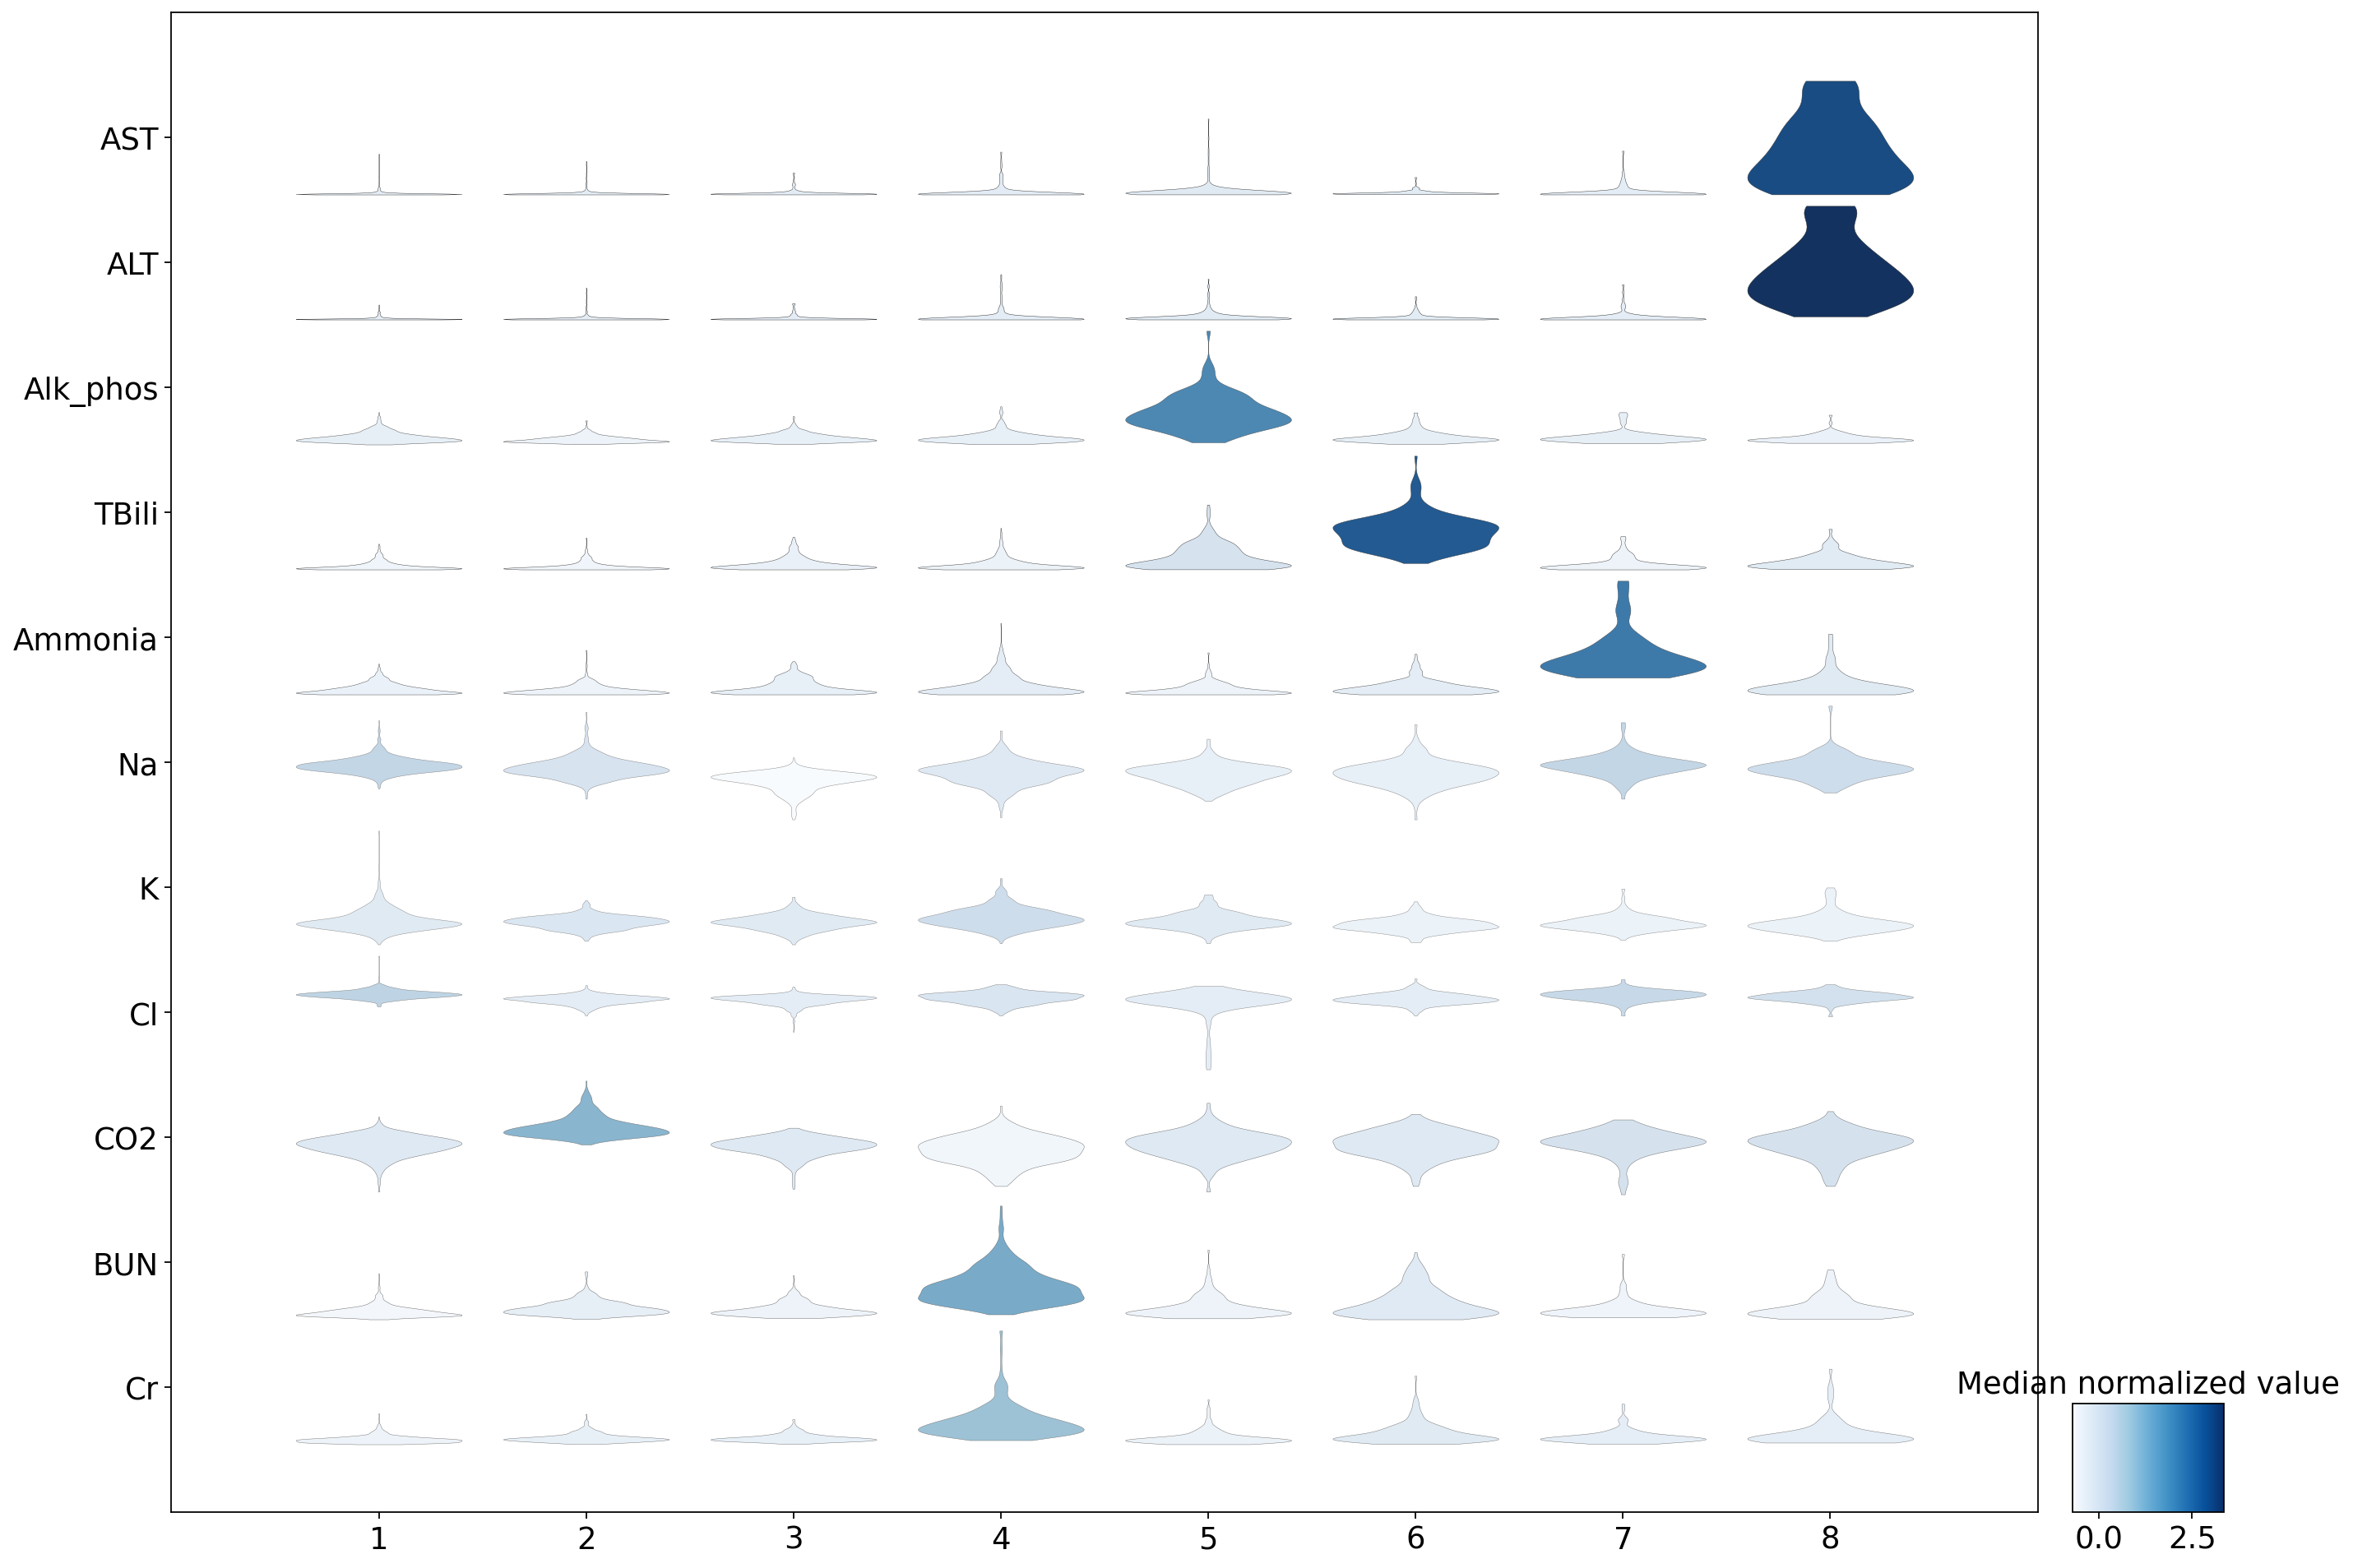

In [32]:
#### THIS WILL ZSCORE DATA be CAREFUL sc.pp.scale(adata, max_value=100)
sc.set_figure_params(scanpy=True, fontsize=20)
sc.pl.stacked_violin(adata,colnames, groupby='leiden', swap_axes=True, dendrogram=False,figsize=(20,15),legend_fontsize=30,colorbar_title='Median normalized value',cmap='Blues',
                    save="stacked_violin_plots_test.pdf")


In [315]:
os.chdir('//wynton//protected//home//ichs//tzack//FLC//')
adata.uns['Dx_colors'] = ['green','yellow','red']

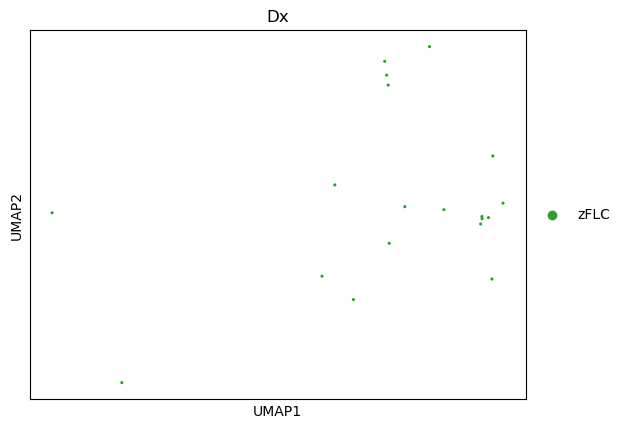

In [313]:
sc.pl.umap(adata_FLC, color=['Dx'],size=20,save='Metabolic_labs_hyperammonemia_umap_only_FLC.pdf')

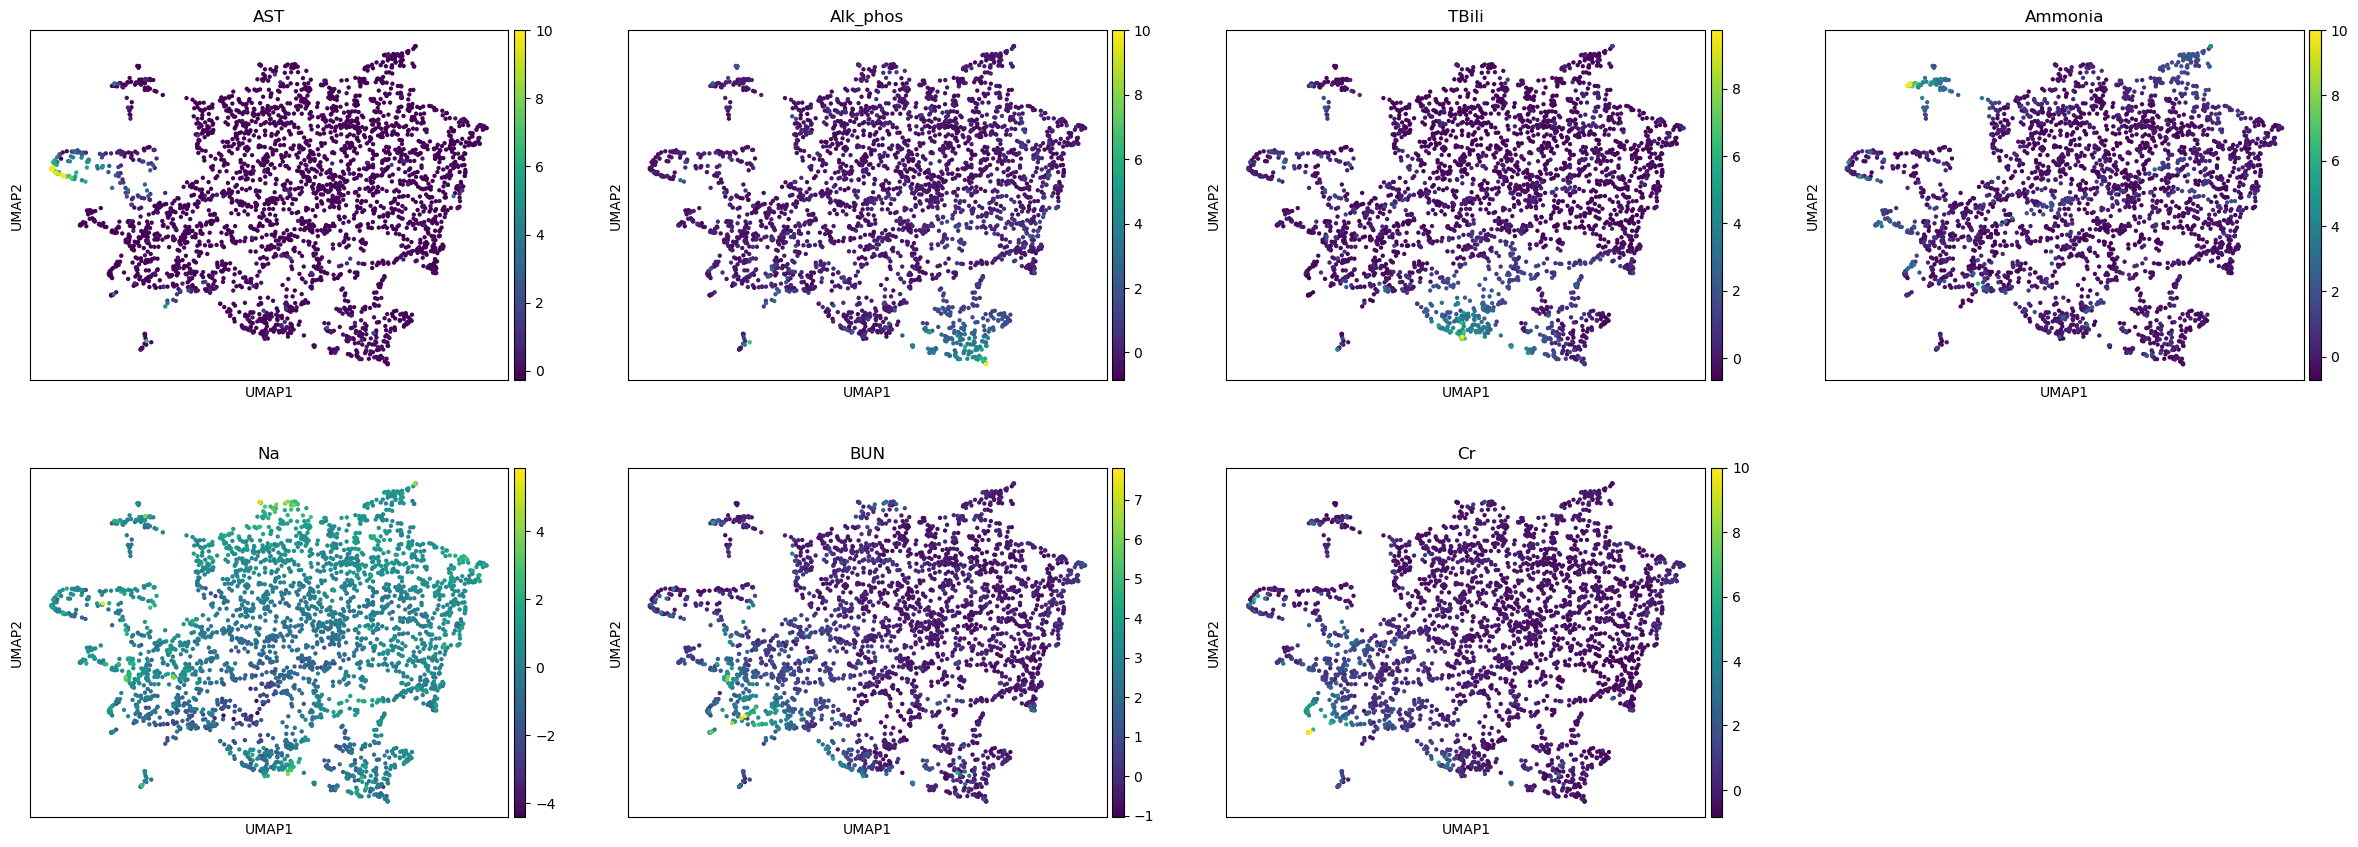

In [210]:
sc.pl.umap(adata, color=['AST','Alk_phos','TBili','Ammonia','Na','BUN','Cr'],save='Metabolic_hyperammonemia_labs_umap_color_by_labs.pdf')

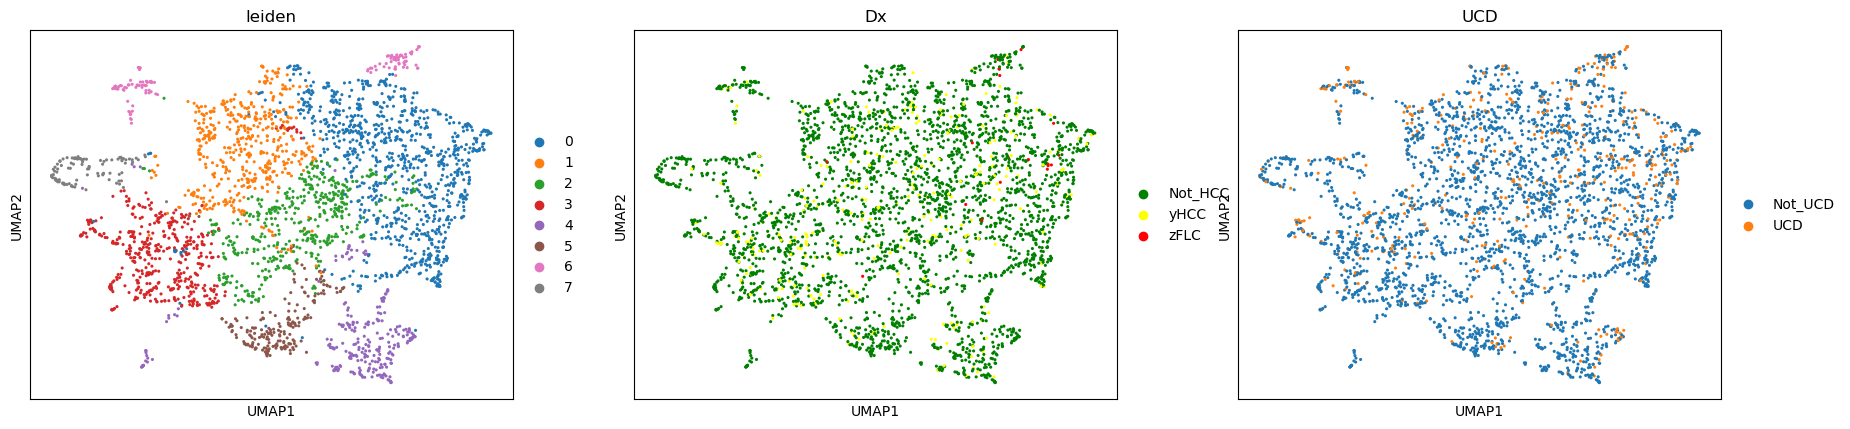

In [326]:
sc.pl.umap(adata, color=['leiden','Dx','UCD'],size=20,save='Metabolic_labs_hyperammonemia_umap_color_by_leiden_UCD_and_Dx.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


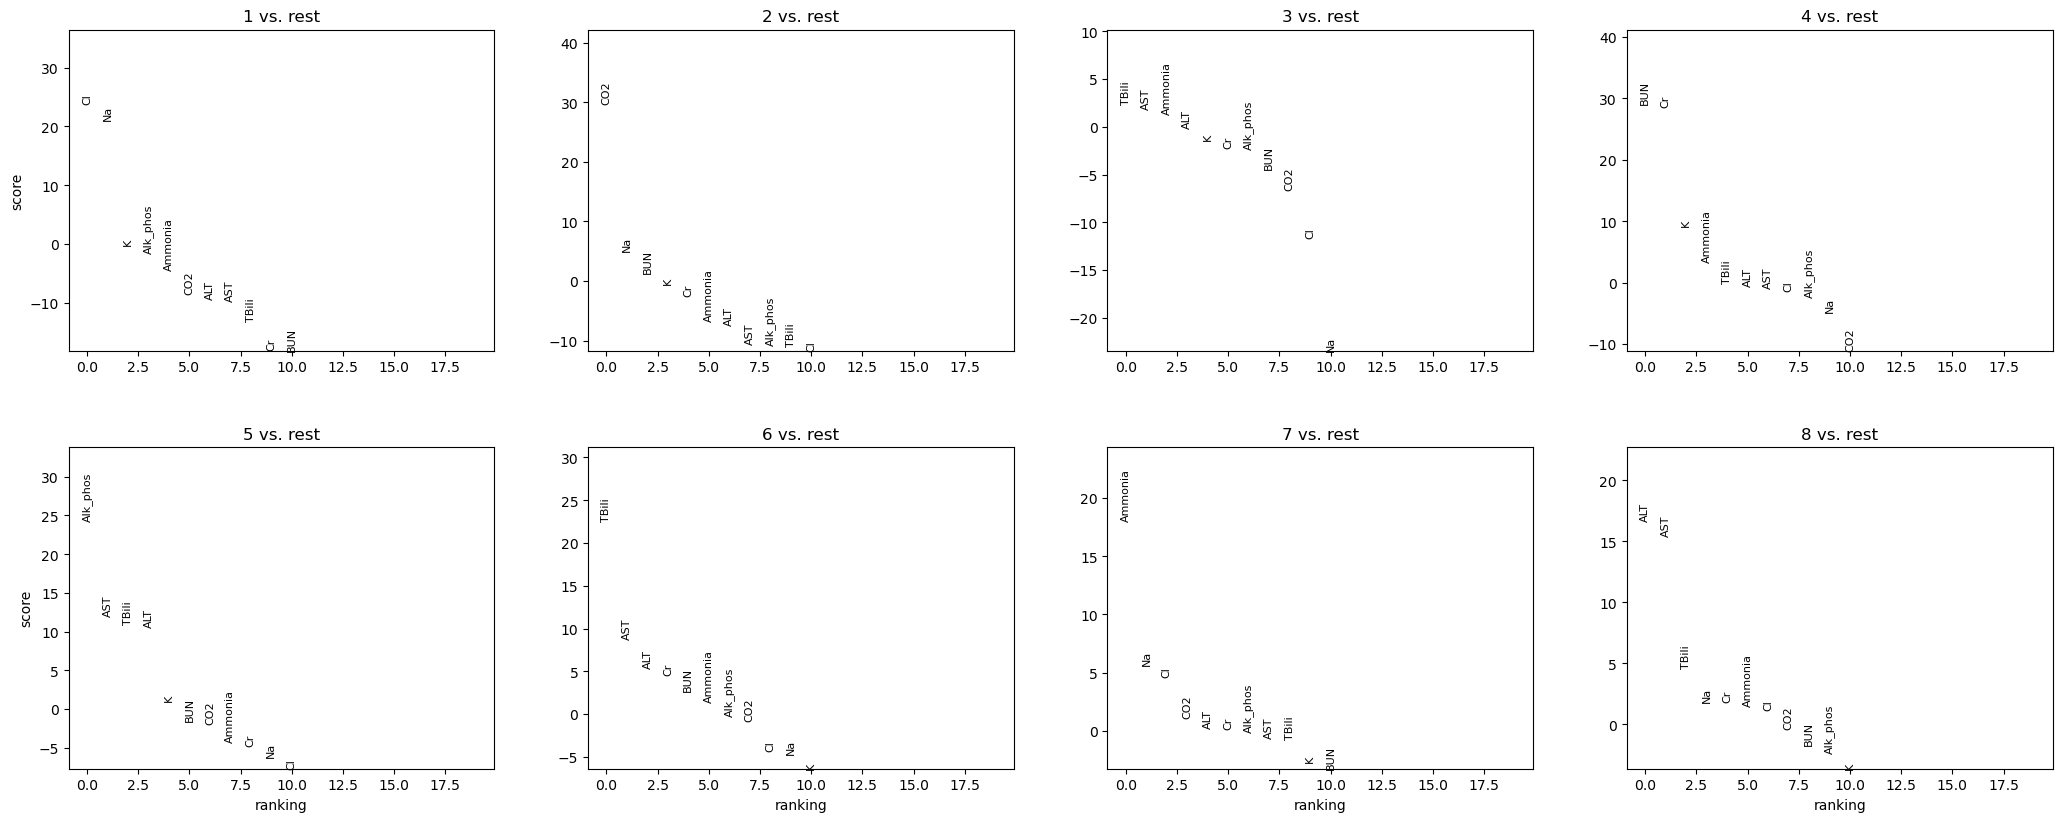

In [62]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, sharey=False,save='Metabolic_labs_hyperammonemia_lab_rank_by_cluster.pdf')

In [271]:
df_data.columns

Index(['PatientDurableKey', 'EncounterKey', 'Date', 'Dx', 'AST', 'ALT',
       'Alk_phos', 'TBili', 'Ammonia', 'WBC', 'RBC', 'PLT', 'MCV', 'Hgb', 'Na',
       'K', 'Cl', 'CO2', 'BUN', 'Cr', 'Dx1'],
      dtype='object')

In [20]:
#Port in urea cycle patients to see how they are distributed
UCD_df = pd.read_csv(flc_dir+"Urea_cycle_disorder_diagnosis_EF_list.csv")
UCD_pt = list(set(UCD_df['PatientDurableKey'].tolist()))
UCD_col = ['Not_UCD']*len(df_labs)
s = 0
for i in range(len(df_data)):
    if df_data.loc[i,'PatientDurableKey'] in UCD_pt:
        s+=1
        UCD_col[i] = 'UCD'
adata.obs['UCD'] = UCD_col


/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Dx' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'UCD' as categorical


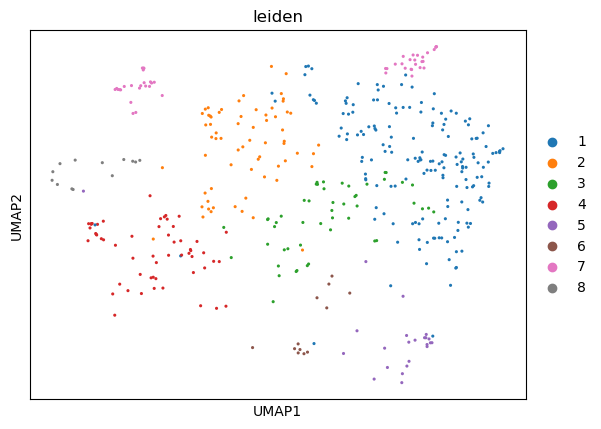

In [21]:
adata_UCD = adata[adata.obs['UCD']=='UCD',:]
sc.pl.umap(adata_UCD, color=['leiden'],size=20,save='Metabolic_labs_hyperammonemia_umap_UCD_only_color_by_leiden.pdf')

In [24]:
os.chdir('//wynton//protected//home//ichs//tzack//FLC//Results_files//')
adata_UCD.write('UCD_adata_results.h5ad')

In [33]:
df_leiden_counts = pd.DataFrame(index=list(range(1,9)),columns=['HCC','FLC','UCD','ALL'])

In [37]:
#creates count table for each cluster for printing
df_leiden_counts = pd.DataFrame(index=list(range(1,9)),columns=['HCC','FLC','UCD','ALL'])
for i in range(1,9):
    df_leiden_counts.loc[i,'UCD'] = sum(adata_UCD.obs['leiden']==str(i))
    df_leiden_counts.loc[i,'FLC'] = sum(adata_FLC.obs['leiden']==str(i))
    df_leiden_counts.loc[i,'HCC'] = sum(adata_HCC.obs['leiden']==str(i))
    df_leiden_counts.loc[i,'ALL'] = sum(adata.obs['leiden']==str(i))

In [38]:
df_leiden_counts.to_csv('leiden_counts_by_Dx.csv')

... storing 'UCD' as categorical


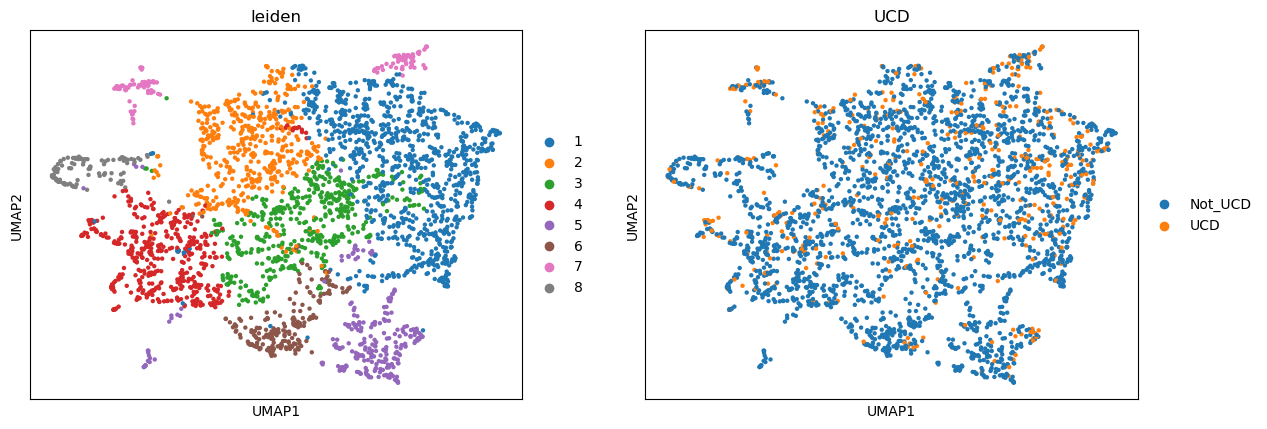

In [21]:
sc.pl.umap(adata, color=['leiden','UCD'],size=40)

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Dx' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'UCD' as categorical


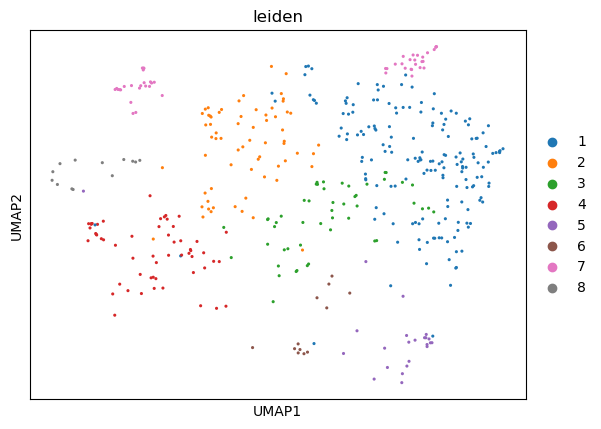

In [22]:
adata_UCD = adata[adata.obs['UCD']=='UCD',:]
sc.pl.umap(adata_UCD, color=['leiden'],size=20,save='Metabolic_labs_hyperammonemia_umap_UCD_only_color_by_leiden.pdf')



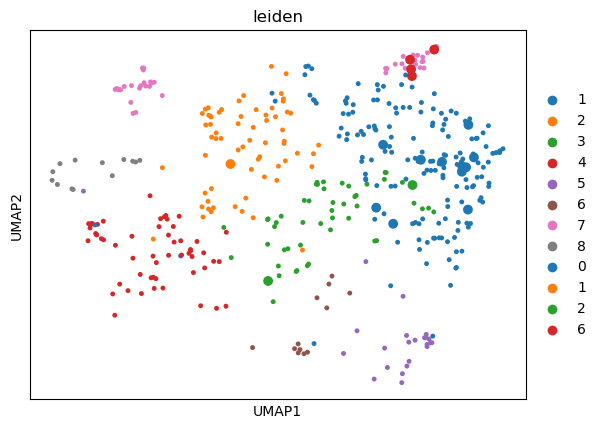

AttributeError: 'NoneType' object has no attribute 'savefig'

In [26]:
ax = sc.pl.umap(adata_UCD, color=['leiden'],size=50,show=False)
sc.pl.umap(
    adata_FLC,
    size=200,
    color=['leiden'],ax=ax,'leiden_with_FLC_and_UCD.eps')

In [45]:
#cluster 6 significant of UCD and FLC
adata_L6 = adata[adata.obs['leiden']=='7',:]
tot_n,m = adata.shape
l6_n,m = adata_L6.shape
s = sum(adata.obs['UCD']=='UCD')
a = sum(adata_L6.obs['UCD']=='UCD')
b = s-a
c = l6_n-a
d = tot_n-a-b-c
urea_cycle_table = np.array([[a, b], [c, d]])
oddsr, p_ucd_l6 = fisher_exact(urea_cycle_table, alternative='greater')
print(p_ucd_l6*8) #eight is the FDR correction
s = sum(adata.obs['Dx']=='zFLC')
tot_n,m = adata.shape
l6_n,m = adata_L6.shape
a = sum(adata_L6.obs['Dx']=='zFLC')
b = s-a
c = l6_n-a
d = tot_n-a-b-c
FLC_table = np.array([[a, b], [c, d]])
oddsr, p_flc_l6 = fisher_exact(FLC_table, alternative='greater')
print(p_flc_l6*8)


s = sum(adata.obs['Dx']=='yHCC')
a = sum(adata_L6.obs['Dx']=='yHCC')
b = s-a
c = l6_n-a
d = tot_n-a-b-c
urea_cycle_table = np.array([[a, b], [c, d]])
oddsr, p_hcc_l6 = fisher_exact(urea_cycle_table, alternative='greater')
print(p_hcc_l6*8)

1.4537325712285978e-11
0.04384105142490554
6.653133721510053


In [46]:
p_hcc_l6

0.8316417151887566

In [49]:
#cluster 0 significant of UCD and FLC
adata_L0 = adata[adata.obs['leiden']=='1',:]
tot_n,m = adata.shape
l0_n,m = adata_L0.shape
s = sum(adata.obs['UCD']=='UCD')
a = sum(adata_L0.obs['UCD']=='UCD')
b = s-a
c = l0_n-a
d = tot_n-a-b-c
urea_cycle_table = np.array([[a, b], [c, d]])
oddsr, p_ucd_l0 = fisher_exact(urea_cycle_table, alternative='greater')
print(p_ucd_l0*8)
s = sum(adata.obs['Dx']=='zFLC')
a = sum(adata_L0.obs['Dx']=='zFLC')
b = s-a
c = l0_n-a
d = tot_n-a-b-c
FLC_table = np.array([[a, b], [c, d]])
oddsr, p_flc_l0 = fisher_exact(FLC_table, alternative='greater')
print(p_flc_l0*8)

s = sum(adata.obs['Dx']=='yHCC')
a = sum(adata_L0.obs['Dx']=='yHCC')
b = s-a
c = l0_n-a
d = tot_n-a-b-c
hcc_table = np.array([[a, b], [c, d]])
oddsr, p_hcc_l0 = fisher_exact(hcc_table, alternative='greater')
print(p_hcc_l0*8)

0.0014225508914692546
0.03816197750915957
7.9834179652607595


In [52]:
#cluster 0 and 6 significant of UCD and FLC
adata_L06 = adata[adata.obs['leiden'].isin(['1','7']),:]
tot_n,m = adata.shape
l06_n,m = adata_L06.shape
s = sum(adata.obs['UCD']=='UCD')
a = sum(adata_L06.obs['UCD']=='UCD')
b = s-a
c = l06_n-a
d = tot_n-a-b-c
urea_cycle_table = np.array([[a, b], [c, d]])
oddsr, p_ucd_l06 = fisher_exact(urea_cycle_table, alternative='greater')
print(p_ucd_l06*28)
s = sum(adata.obs['Dx']=='zFLC')
a = sum(adata_L06.obs['Dx']=='zFLC')
b = s-a
c = l06_n-a
d = tot_n-a-b-c
FLC_table = np.array([[a, b], [c, d]])
oddsr, p_flc_l06 = fisher_exact(FLC_table, alternative='greater')
print(p_flc_l06*28)

2.9852421630831645e-10
0.0005337667026665995


In [53]:
a = 3
b = 12
c = 81
d = 1356
hyperammonia_table = np.array([[a, b], [c, d]])
fisher_exact(hyperammonia_table, alternative='greater')

(4.185185185185185, 0.05129743907404097)

0.0005337667026665995

In [253]:
sc.pp.neighbors(adata_L6, n_neighbors=3, n_pcs=40,metric='minkowski')
sc.tl.umap(adata_L6,min_dist=0.2)
sc.tl.leiden(adata_L6,key_added='leiden',resolution = 0.15)

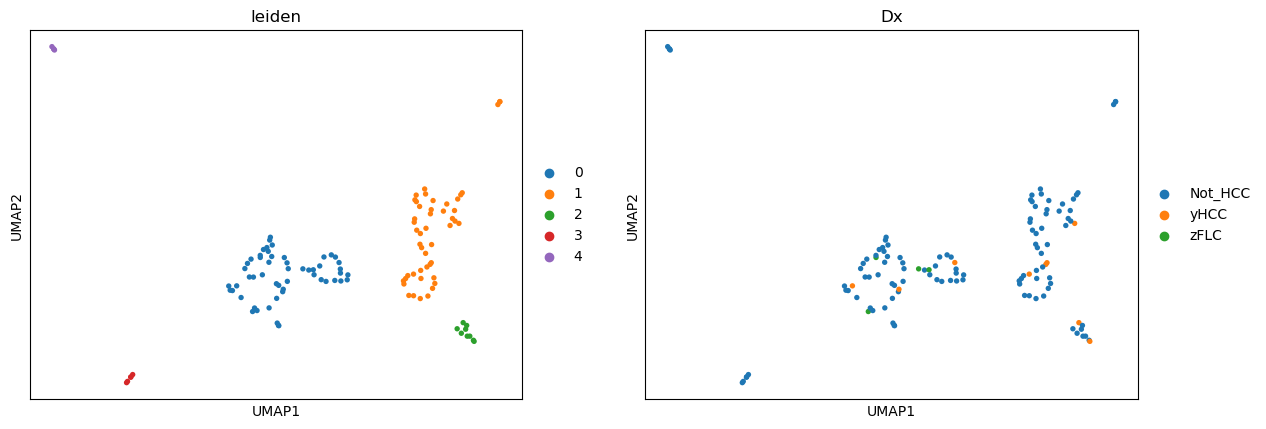

In [254]:
sc.pl.umap(adata_L6, color=['leiden','Dx'],size=60,save='Recluster_Cluster_6_Metabolic_labs_hyperammonemia_umap_color_by_leiden_and_Dx.pdf')

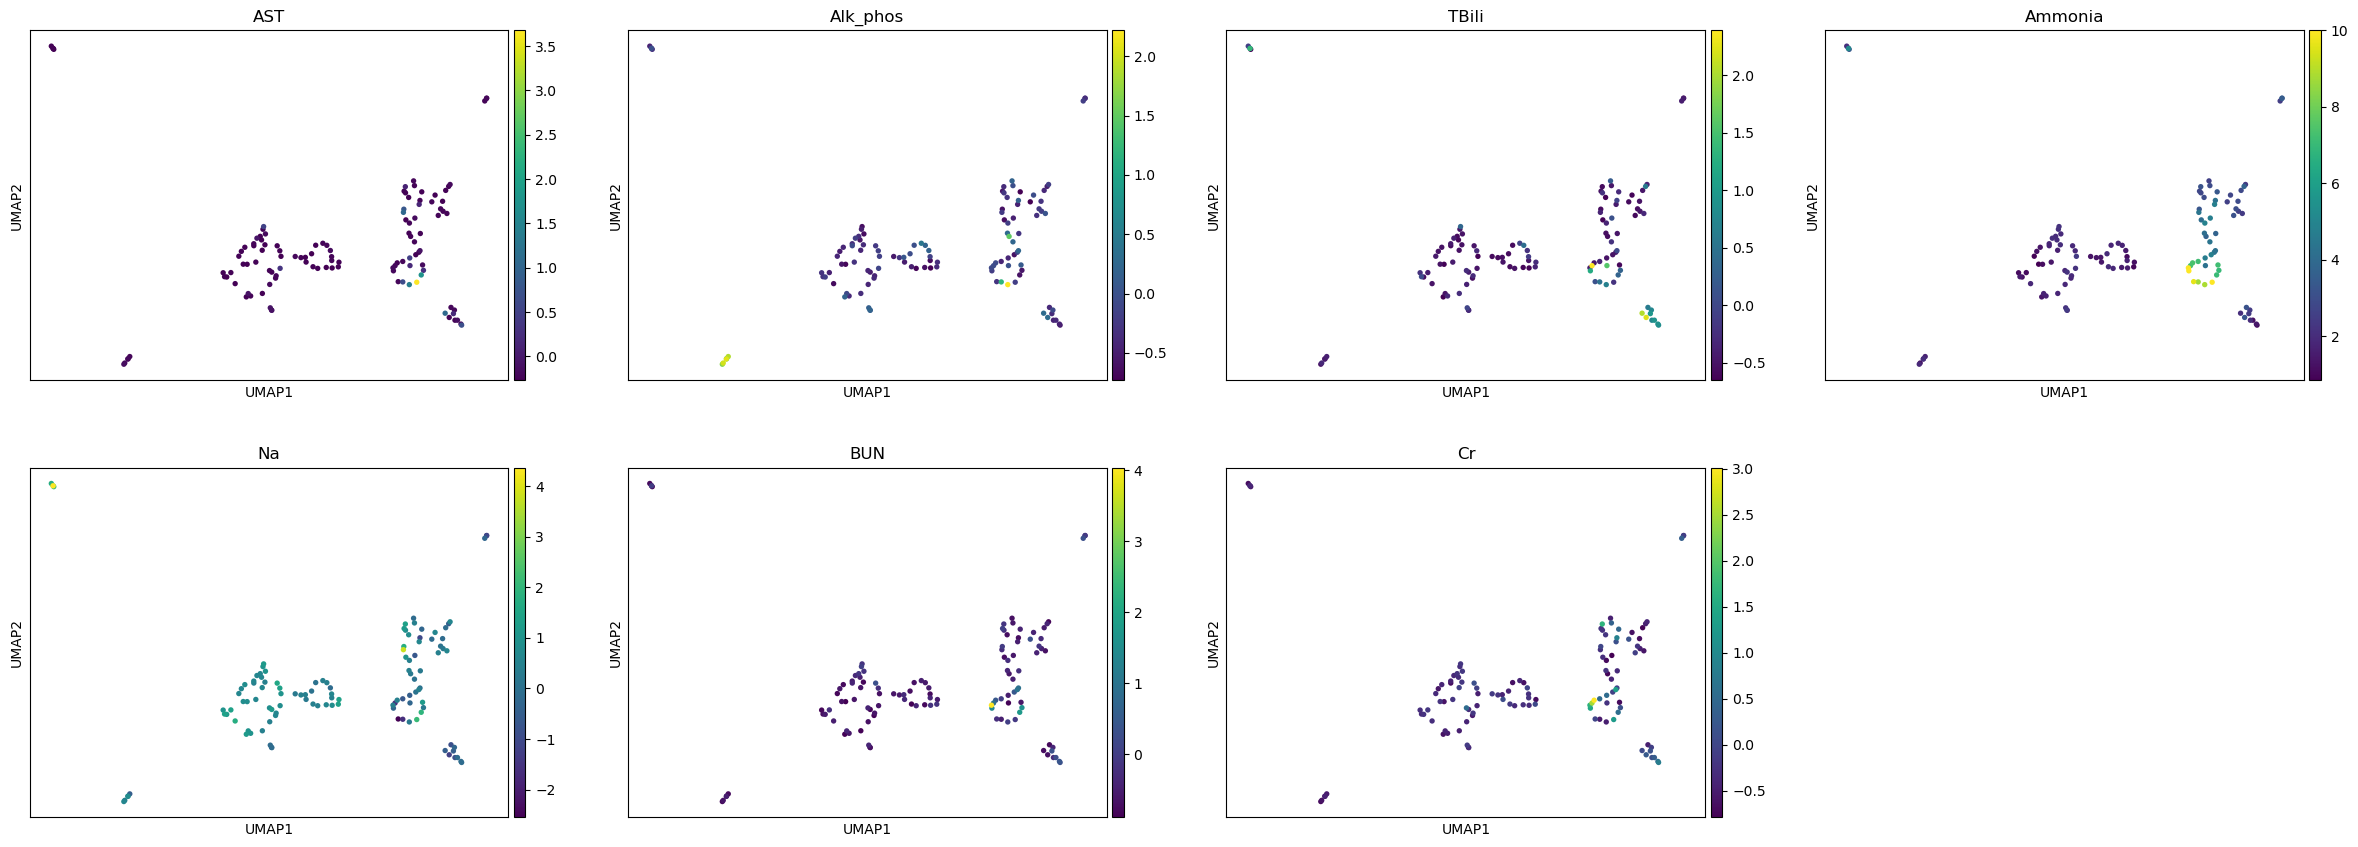

In [207]:
sc.pl.umap(adata_L6,size=60, color=['AST','Alk_phos','TBili','Ammonia','Na','BUN','Cr'],save='Recluster_L6_Metabolic_hyperammonemia_labs_umap_color_by_labs.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


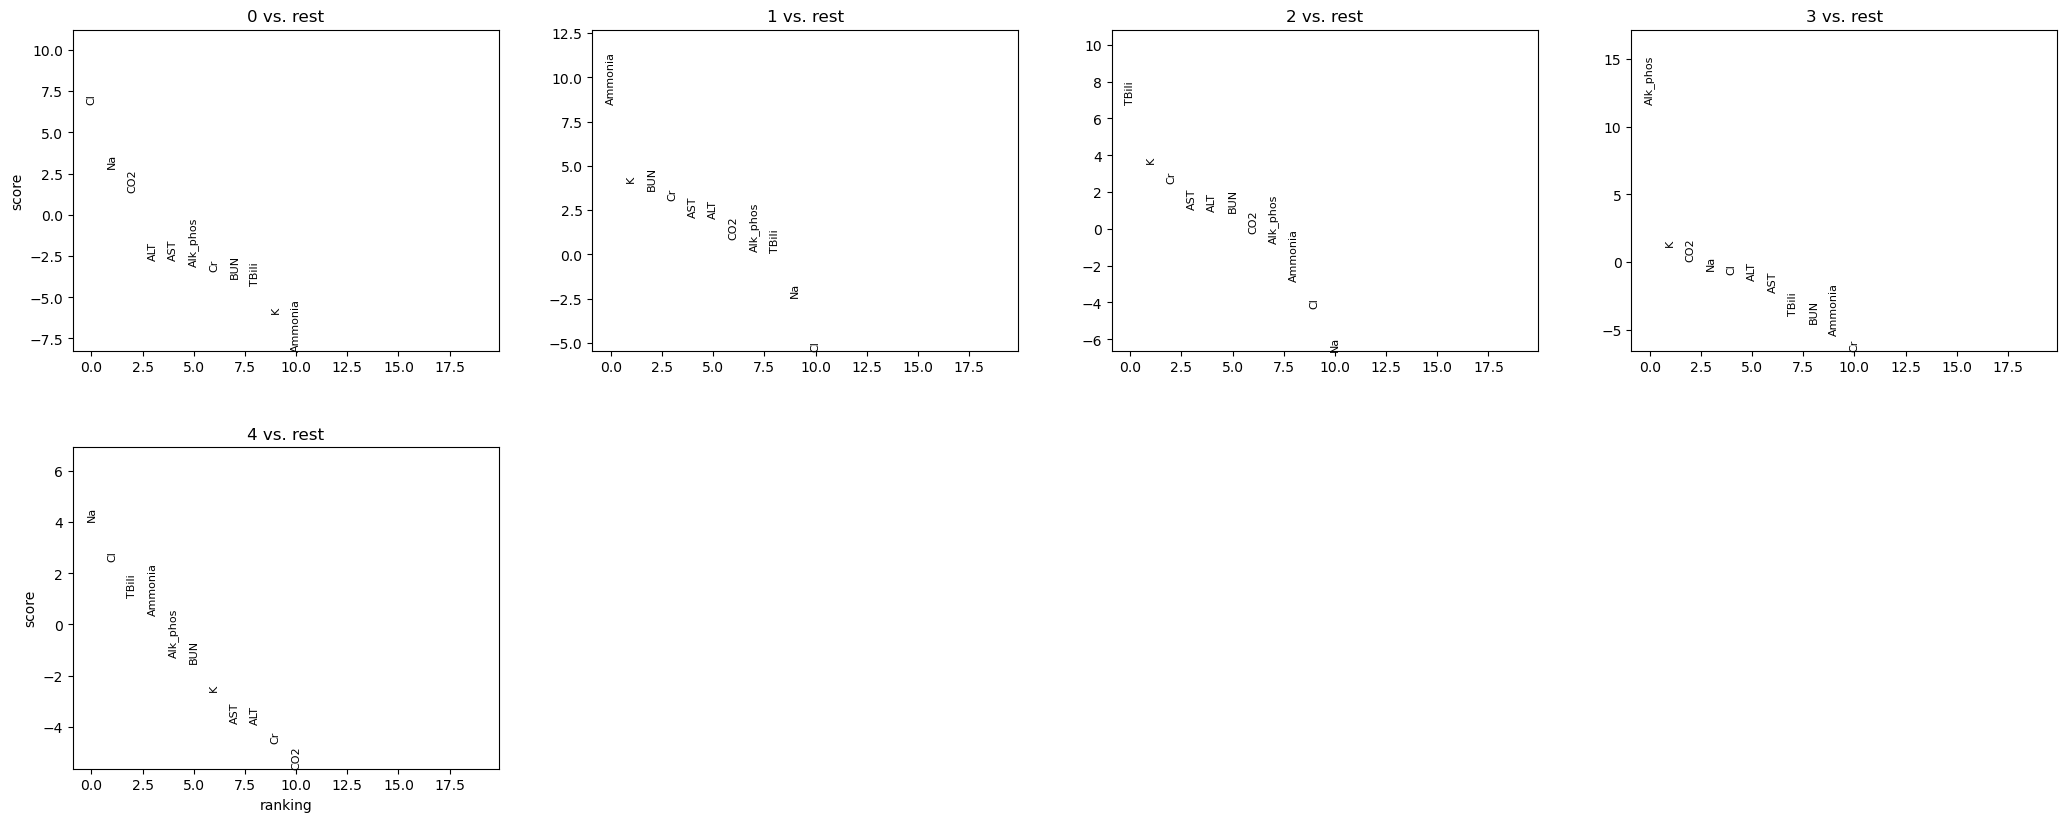

In [203]:
sc.tl.rank_genes_groups(adata_L6, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_L6,groupby='leiden', sharey=False,save='Recluster6_Metabolic_labs_hyperammonemia_lab_rank_by_cluster.pdf')

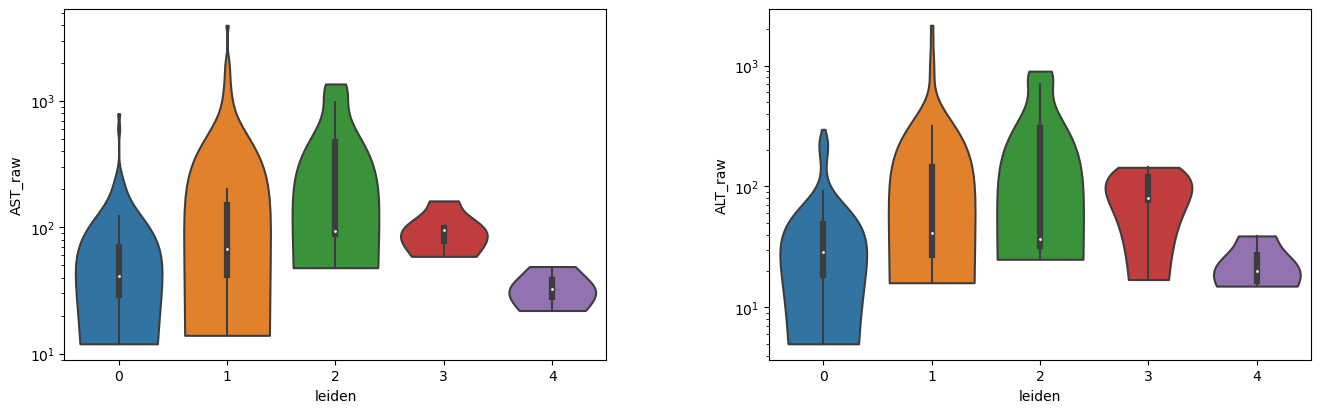

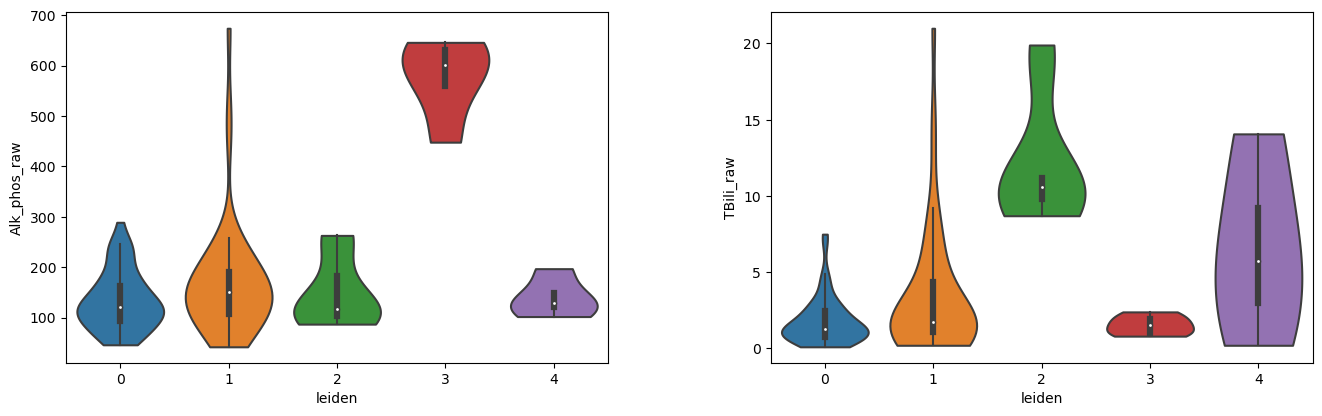

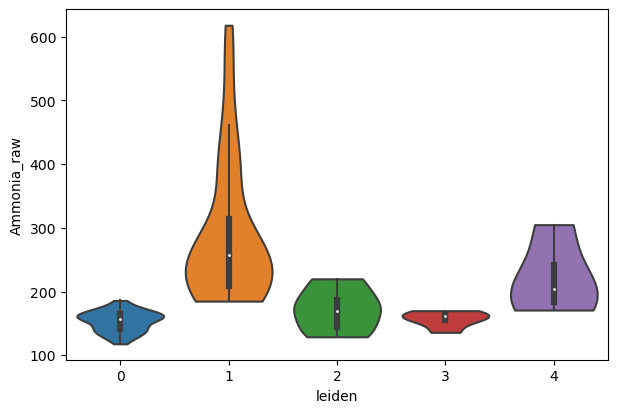

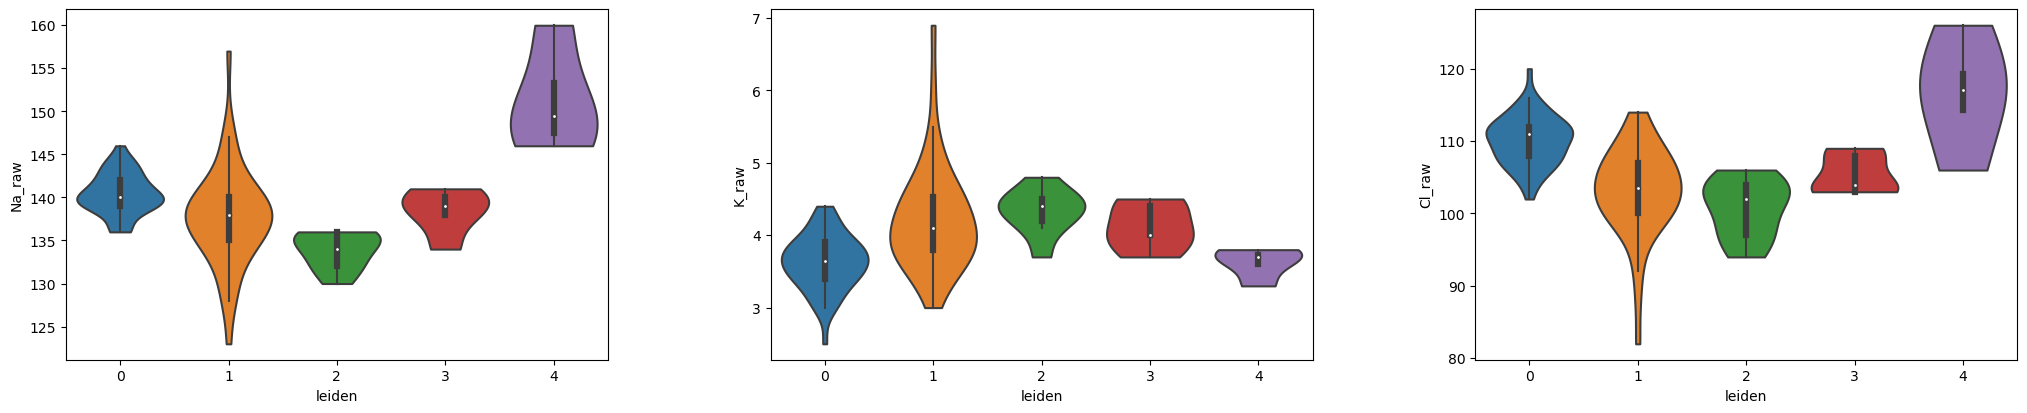

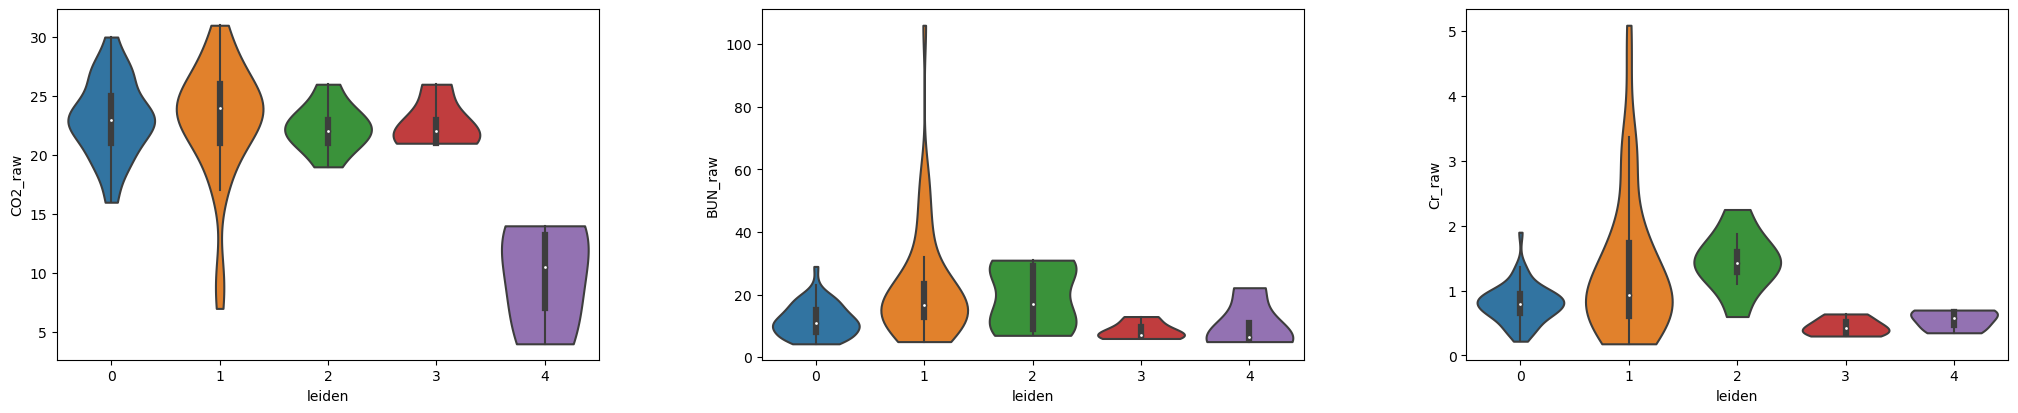

In [255]:
os.chdir('//wynton//protected//home//ichs//tzack//FLC//figures//Violin_plots//')
sc.pl.violin(adata_L6, ['AST_raw','ALT_raw'], log=True,groupby='leiden', stripplot=False, inner='box',save="ReCluster_AST_ALT_Violin_plots_logscale_by_leiden.pdf")  
sc.pl.violin(adata_L6, ['Alk_phos_raw','TBili_raw'], groupby='leiden', stripplot=False, inner='box',save="ReCluster_Alkphos_TBili_Violin_plots_by_leiden.pdf") # use stripplot=False to remove the internal dots, inner='box' adds a boxplot inside violins
sc.pl.violin(adata_L6, ['Ammonia_raw'], groupby='leiden', stripplot=False, inner='box',save="ReCluster_Ammonia_Violin_plot_by_leiden.pdf")
sc.pl.violin(adata_L6, ['Na_raw','K_raw','Cl_raw'], groupby='leiden', stripplot=False, inner='box',save="ReCluster_Na_Cl_K_Violin_plot_by_leiden.pdf")
sc.pl.violin(adata_L6, ['CO2_raw','BUN_raw','Cr_raw'], groupby='leiden', stripplot=False, inner='box',save="ReCluster_CO2_BUN_Cr_Violin_plot_by_leiden.pdf")

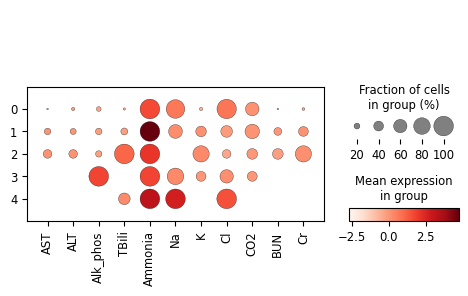

In [208]:
sc.pl.dotplot(adata_L6, ['AST', 'ALT', 'Alk_phos', 'TBili', 'Ammonia','Na', 'K', 'Cl', 'CO2', 'BUN', 'Cr'], groupby='leiden', save ='Recluster_L6_Metabolic_labs_hyperammonemia_dotplot.pdf' );

In [263]:
adata_L6[adata_L6.obs['leiden']=='2',:].obs.index

Index(['DF01099007D04F', 'DECD0CB1A446FE', 'DF1C18BD42E25A', 'D0603100DE5CE2',
       'D15ED6C43C42C1', 'DD9FFC32FF496C', 'D0E653D8E5E1AC', 'DF7D69BDB423C9',
       'D23529E6FFB52B'],
      dtype='object')